# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    
    # additional features added by me (?, All caps)
    movie_data['quest_count'] = movie_data['review'].str.count("\?")
    movie_data['all_caps'] = movie_data['review'].str.isupper().astype(int)

    X_quant_features = movie_data[["word_count", "punc_count", "quest_count", "all_caps"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/johanna/Documents/Parsons/ML/ml-master/moviereviews_train.tsv', my_random_seed=19)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  quest_count  all_caps
0         433          20            2         0
1         158          16            0         0
2        

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [86]:
from sklearn import linear_model
ols = linear_model.SGDClassifier()
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 9964, 'TN': 10036, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'ols_train'}


### MODEL: SVM, linear

Discussion Assignment 3 showed that the accuracy of the test set could be improved by changing the SGD Classifier's alpha value. My initial experiments showed that 1 is close to an ideal value for this alpha. After testing the outcomes of several values between 1 and 10, I settled with 4.1 as the best option. 

In [44]:
from sklearn import linear_model
#svm = linear_model.SGDClassifier(alpha=1)
#svm = linear_model.SGDClassifier(alpha=5)
#svm = linear_model.SGDClassifier(alpha=3)
#svm = linear_model.SGDClassifier(alpha=4)
svm = linear_model.SGDClassifier(alpha=4.02)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 9750, 'TN': 9900, 'FP': 136, 'FN': 214, 'Accuracy': 0.9825, 'Precision': 0.9862431721626542, 'Recall': 0.9785226816539543, 'desc': 'svm_train'}
{'Pos': 2536, 'Neg': 2464, 'TP': 2238, 'TN': 2178, 'FP': 286, 'FN': 298, 'Accuracy': 0.8832, 'Precision': 0.8866877971473851, 'Recall': 0.8824921135646687, 'desc': 'svm_test'}


I did some research to find the most valuable parameters of the SDG Classifier and picked alpha, learning_rate

To make it easier to see and compare the impact of several parameters on my model, I created for loops

In [45]:
#Testing the learning rate parameter

from sklearn import linear_model
alphas = [4.02]
learning_rate = ['optimal','constant','invscaling','adaptive']
eta0s = [0.1,10,100]
#losses = ['hinge','modified_huber','squared_hinge']


for alpha in alphas:
    for lr in learning_rate:
    #for loss in losses:
        for eta0 in eta0s:
        
            svm = linear_model.SGDClassifier(alpha=alpha, eta0=eta0, max_iter=5000)
            svm.fit(X_train, y_train)

            svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
            svm_performance_train.compute_measures()
            print()
            print(f'Res for alpha={alpha}, lr={lr}, eta0={eta0}: ', svm_performance_train.performance_measures)
            #print(f'Res for alpha={alpha}, loss={loss}: ', svm_performance_train.performance_measures)

            svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
            svm_performance_test.compute_measures()
            print(f'Test set : Res for alpha={alpha}, lr={lr}, eta0={eta0}: ',svm_performance_test.performance_measures)
            #print(f'Test set : Res for alpha={alpha}, loss={loss}: ',svm_performance_test.performance_measures)
            print()


Res for alpha=4.02, lr=optimal, eta0=0.1:  {'Pos': 9964, 'Neg': 10036, 'TP': 9752, 'TN': 9903, 'FP': 133, 'FN': 212, 'Accuracy': 0.98275, 'Precision': 0.9865452706120384, 'Recall': 0.9787234042553191, 'desc': 'svm_train'}
Test set : Res for alpha=4.02, lr=optimal, eta0=0.1:  {'Pos': 2536, 'Neg': 2464, 'TP': 2235, 'TN': 2181, 'FP': 283, 'FN': 301, 'Accuracy': 0.8832, 'Precision': 0.8876092136616363, 'Recall': 0.8813091482649842, 'desc': 'svm_test'}


Res for alpha=4.02, lr=optimal, eta0=10:  {'Pos': 9964, 'Neg': 10036, 'TP': 9750, 'TN': 9907, 'FP': 129, 'FN': 214, 'Accuracy': 0.98285, 'Precision': 0.9869419981779533, 'Recall': 0.9785226816539543, 'desc': 'svm_train'}
Test set : Res for alpha=4.02, lr=optimal, eta0=10:  {'Pos': 2536, 'Neg': 2464, 'TP': 2231, 'TN': 2178, 'FP': 286, 'FN': 305, 'Accuracy': 0.8818, 'Precision': 0.88637266587207, 'Recall': 0.8797318611987381, 'desc': 'svm_test'}


Res for alpha=4.02, lr=optimal, eta0=100:  {'Pos': 9964, 'Neg': 10036, 'TP': 9752, 'TN': 9901, 

In [46]:
#Testing the loss parameter

from sklearn import linear_model
alphas = [4.02]
#learning_rate = ['constant','invscaling','adaptive']
#eta0s = [0.1,0.2,0.3]
losses = ['hinge','modified_huber','squared_hinge','perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']


for alpha in alphas:
    #for lr in learning_rate:
    for loss in losses:
        #for eta0 in eta0s:
        
            svm = linear_model.SGDClassifier(alpha=alpha, loss=loss, max_iter=5000)
            svm.fit(X_train, y_train)

            svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
            svm_performance_train.compute_measures()
            print()
            #print(f'Res for alpha={alpha}, lr={lr}, eta0={eta0}: ', svm_performance_train.performance_measures)
            print(f'Res for alpha={alpha}, loss={loss}: ', svm_performance_train.performance_measures)

            svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
            svm_performance_test.compute_measures()
            #print(f'Test set : Res for alpha={alpha}, lr={lr}, eta0={eta0}: ',svm_performance_test.performance_measures)
            print(f'Test set : Res for alpha={alpha}, loss={loss}: ',svm_performance_test.performance_measures)
            print()


Res for alpha=4.02, loss=hinge:  {'Pos': 9964, 'Neg': 10036, 'TP': 9760, 'TN': 9900, 'FP': 136, 'FN': 204, 'Accuracy': 0.983, 'Precision': 0.9862570735650767, 'Recall': 0.9795262946607788, 'desc': 'svm_train'}
Test set : Res for alpha=4.02, loss=hinge:  {'Pos': 2536, 'Neg': 2464, 'TP': 2241, 'TN': 2173, 'FP': 291, 'FN': 295, 'Accuracy': 0.8828, 'Precision': 0.8850710900473934, 'Recall': 0.8836750788643533, 'desc': 'svm_test'}


Res for alpha=4.02, loss=modified_huber:  {'Pos': 9964, 'Neg': 10036, 'TP': 9919, 'TN': 10005, 'FP': 31, 'FN': 45, 'Accuracy': 0.9962, 'Precision': 0.9968844221105527, 'Recall': 0.9954837414692894, 'desc': 'svm_train'}
Test set : Res for alpha=4.02, loss=modified_huber:  {'Pos': 2536, 'Neg': 2464, 'TP': 2266, 'TN': 2153, 'FP': 311, 'FN': 270, 'Accuracy': 0.8838, 'Precision': 0.8793170353123787, 'Recall': 0.8935331230283912, 'desc': 'svm_test'}


Res for alpha=4.02, loss=squared_hinge:  {'Pos': 9964, 'Neg': 10036, 'TP': 9945, 'TN': 8392, 'FP': 1644, 'FN': 19, 'A

/Users/johanna/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



Res for alpha=4.02, loss=squared_error:  {'Pos': 9964, 'Neg': 10036, 'TP': 3281, 'TN': 6628, 'FP': 3408, 'FN': 6683, 'Accuracy': 0.49545, 'Precision': 0.49050680221258786, 'Recall': 0.3292854275391409, 'desc': 'svm_train'}
Test set : Res for alpha=4.02, loss=squared_error:  {'Pos': 2536, 'Neg': 2464, 'TP': 865, 'TN': 1633, 'FP': 831, 'FN': 1671, 'Accuracy': 0.4996, 'Precision': 0.5100235849056604, 'Recall': 0.34108832807570977, 'desc': 'svm_test'}


Res for alpha=4.02, loss=huber:  {'Pos': 9964, 'Neg': 10036, 'TP': 8350, 'TN': 9867, 'FP': 169, 'FN': 1614, 'Accuracy': 0.91085, 'Precision': 0.9801619908439958, 'Recall': 0.8380168606985147, 'desc': 'svm_train'}
Test set : Res for alpha=4.02, loss=huber:  {'Pos': 2536, 'Neg': 2464, 'TP': 1819, 'TN': 2309, 'FP': 155, 'FN': 717, 'Accuracy': 0.8256, 'Precision': 0.9214792299898683, 'Recall': 0.7172712933753943, 'desc': 'svm_test'}


Res for alpha=4.02, loss=epsilon_insensitive:  {'Pos': 9964, 'Neg': 10036, 'TP': 9782, 'TN': 9914, 'FP': 122, 

Most Interesting Result: 

Res for alpha=4.02, loss=squared_hinge:  {'Pos': 9964, 'Neg': 10036, 'TP': 9931, 'TN': 8348, 'FP': 1688, 'FN': 33, 'Accuracy': 0.91395, 'Precision': 0.8547207160685085, 'Recall': 0.996688077077479, 'desc': 'svm_train'}
Test set : Res for alpha=4.02, loss=squared_hinge:  {'Pos': 2536, 'Neg': 2464, 'TP': 2155, 'TN': 1727, 'FP': 737, 'FN': 381, 'Accuracy': 0.7764, 'Precision': 0.7451590594744122, 'Recall': 0.8497634069400631, 'desc': 'svm_test'}

### Submission MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=4.02, loss='modified_huber', max_iter=10000)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 9914, 'TN': 10006, 'FP': 30, 'FN': 50, 'Accuracy': 0.996, 'Precision': 0.9969831053901851, 'Recall': 0.9949819349658772, 'desc': 'svm_train'}
{'Pos': 2536, 'Neg': 2464, 'TP': 2245, 'TN': 2169, 'FP': 295, 'FN': 291, 'Accuracy': 0.8828, 'Precision': 0.8838582677165354, 'Recall': 0.8852523659305994, 'desc': 'svm_test'}


### MODEL: logistic regression

In [88]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 9964, 'TN': 10036, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [89]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 9549, 'TN': 9873, 'FP': 163, 'FN': 415, 'Accuracy': 0.9711, 'Precision': 0.9832166392092258, 'Recall': 0.9583500602167804, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [90]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 9964, 'TN': 10036, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [91]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 9964, 'TN': 10036, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [92]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9964, 'Neg': 10036, 'TP': 7398, 'TN': 8078, 'FP': 1958, 'FN': 2566, 'Accuracy': 0.7738, 'Precision': 0.7907225309961522, 'Recall': 0.7424729024488157, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

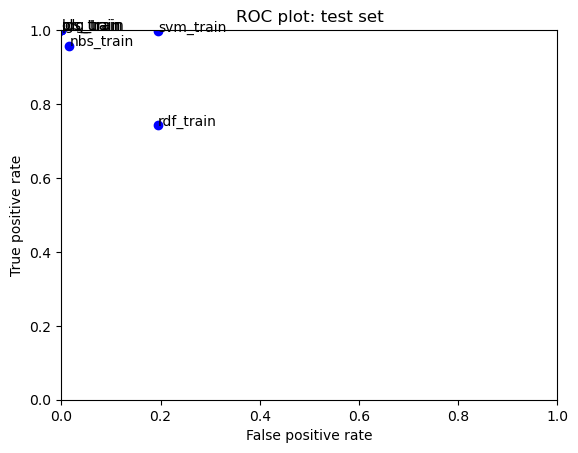

In [93]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [94]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [95]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [59]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2536, 'Neg': 2464, 'TP': 2122, 'TN': 2011, 'FP': 453, 'FN': 414, 'Accuracy': 0.8266, 'Precision': 0.8240776699029126, 'Recall': 0.8367507886435331, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [60]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2536, 'Neg': 2464, 'TP': 2155, 'TN': 1688, 'FP': 776, 'FN': 381, 'Accuracy': 0.7686, 'Precision': 0.7352439440464006, 'Recall': 0.8497634069400631, 'desc': 'svm_test'}


### MODEL: logistic regression

In [61]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2536, 'Neg': 2464, 'TP': 2121, 'TN': 2042, 'FP': 422, 'FN': 415, 'Accuracy': 0.8326, 'Precision': 0.8340542666142352, 'Recall': 0.8363564668769716, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [62]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2536, 'Neg': 2464, 'TP': 1869, 'TN': 1863, 'FP': 601, 'FN': 667, 'Accuracy': 0.7464, 'Precision': 0.7566801619433199, 'Recall': 0.73698738170347, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [63]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2536, 'Neg': 2464, 'TP': 2080, 'TN': 2037, 'FP': 427, 'FN': 456, 'Accuracy': 0.8234, 'Precision': 0.8296769046669326, 'Recall': 0.8201892744479495, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [64]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2536, 'Neg': 2464, 'TP': 2098, 'TN': 1962, 'FP': 502, 'FN': 438, 'Accuracy': 0.812, 'Precision': 0.806923076923077, 'Recall': 0.8272870662460567, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [65]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2536, 'Neg': 2464, 'TP': 1832, 'TN': 1973, 'FP': 491, 'FN': 704, 'Accuracy': 0.761, 'Precision': 0.7886353852776582, 'Recall': 0.722397476340694, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

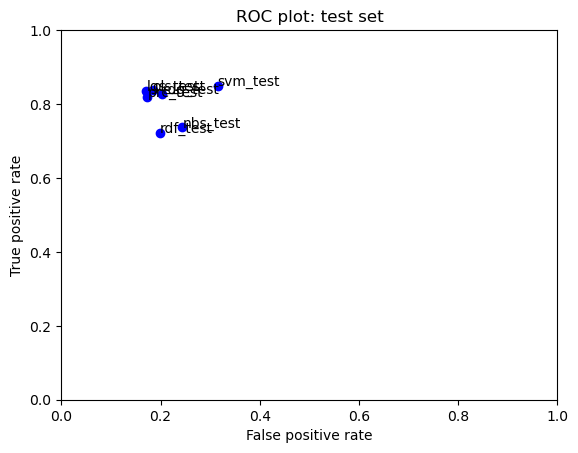

In [66]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [7]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/johanna/Documents/Parsons/ML/ml-master/moviereviews_test.tsv', my_random_seed=19, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  quest_count  all_caps
0         131           5            0         0
1         169          15            0         0
2         176          18            0         0
3         112           5            0         0
4         133           8            0       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [9]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])

# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)

# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.47468


In [10]:
raw_data.head()

,id,review,word_count,punc_count,quest_count,all_caps
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0,0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,0,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0,0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0,0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0,0


In [11]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [12]:
my_submission.shape

(25000, 2)

In [13]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/johanna/Documents/Parsons/ML/ml-master/submission_2.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation